# 1. Setup

## 1.1 Installing Dependencies

In [15]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [16]:
!pip install tensorflow==2.6.0 

In [17]:
!pip install tensorflow-gpu==2.6.0

In [18]:
!pip install opencv-python matplotlib

## 1.2 Importing Dependencies

In [19]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [20]:
import tensorflow as tf

In [21]:
pip install keras==2.6.*

Note: you may need to restart the kernel to use updated packages.


In [22]:
from tensorflow.keras.layers import Embedding

In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten


## 1.3 Setting GPU Growth

In [24]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## 1.4 Creating Folder Structures

In [25]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [138]:
POS_PATH 

'data\\positive'

In [ ]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 2. Collecting Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [26]:
# http://vis-www.cs.umass.edu/lfw/
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [27]:
# Moving LFW Images to the following repository data/negative

for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

## 2.2 Collect Positive and Anchor Classes

In [28]:
import uuid # Import uuid library to generate unique image names

In [29]:
uuid??



UUID objects (universally unique identifiers) according to RFC 4122.

This module provides immutable UUID objects (class UUID) and the functions
uuid1(), uuid3(), uuid4(), uuid5() for generating version 1, 3, 4, and 5
UUIDs as specified in RFC 4122.

If all you want is a unique ID, you should probably call uuid1() or uuid4().
Note that uuid1() may compromise privacy since it creates a UUID containing
the computer's network address.  uuid4() creates a random UUID.

In [30]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\01d50b7a-db49-11ec-a1b4-2c8db1d65e0b.jpg'

In [32]:
# Establishing a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [33]:
frame.shape

(250, 250, 3)

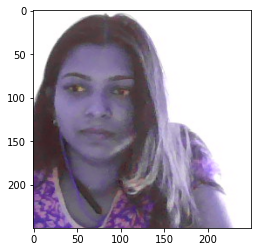

In [38]:
plt.imshow(frame[:250,:200+250, :])

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [39]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [40]:
dir_test = anchor.as_numpy_iterator()

In [41]:
print(dir_test.next())

b'data\\anchor\\880e0243-c7c4-11ec-9cee-2c8db1d65e0b.jpg'


## 3.2 Preprocessing - Scale and Resize

In [42]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [43]:
img = preprocess('data\\anchor\\881ea707-c7c4-11ec-a784-2c8db1d65e0b.jpg')

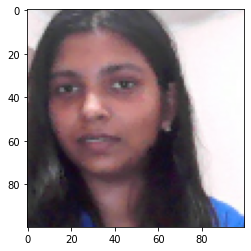

In [47]:
plt.imshow(img)

In [48]:
img.numpy().max() 

1.0

In [49]:
img.numpy().min() 

0.013480392




## 3.3 Create Labelled Dataset

In [50]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [51]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [52]:
samples = data.as_numpy_iterator()

In [53]:
exampple = samples.next()

In [54]:
exampple

(b'data\\anchor\\8ecfd04c-c7c4-11ec-bc98-2c8db1d65e0b.jpg',
 b'data\\positive\\8884e1a0-c7c4-11ec-b458-2c8db1d65e0b.jpg',
 1.0)

## 3.4 Build Train and Test Partition

In [63]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [64]:
res = preprocess_twin(*exampple)

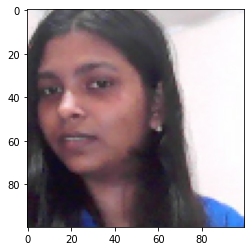

In [65]:
plt.imshow(res[1])

In [66]:
res[2]

1.0

In [67]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [68]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [69]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [70]:
inp = Input(shape=(100,100,3))


In [71]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [72]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [73]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [74]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [75]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [76]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [77]:
mod.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0 

In [78]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [79]:
embedding = make_embedding()

In [80]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 9, 128)         0 

# 4.2 Build Distance Layer


In [89]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [90]:
l1 = L1Dist()

In [91]:
l1(anchor_embedding, validation_embedding)

NameError: name 'anchor_embedding' is not defined

# 4.3 Make Siamese Model

In [92]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [93]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [94]:
siamese_layer = L1Dist()

In [95]:
distances = siamese_layer(inp_embedding, val_embedding)

In [96]:
classifier = Dense(1, activation='sigmoid')(distances)

In [97]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [98]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [99]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_3 (L1Dist)              (None, 4096)         0           embedding[0][0]     

In [100]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [101]:
siamese_model = make_siamese_model()

In [102]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[2][0]     

# 5. Training

## 5.1 Setup Loss and Optimizer 

In [103]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [104]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints

In [105]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

# 5.3 Build Train Step Function 

In [106]:
test_batch = train_data.as_numpy_iterator()

In [107]:
batch_1 = test_batch.next()

In [108]:
X = batch_1[:2]

In [109]:
y = batch_1[2]

In [110]:
y

array([1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.],
      dtype=float32)

In [111]:
tf.losses.BinaryCrossentropy??

Init signature:
tf.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0,
    axis=-1,
    reduction='auto',
    name='binary_crossentropy',
)
Source:        
@keras_export('keras.losses.BinaryCrossentropy')
class BinaryCrossentropy(LossFunctionWrapper):
  """Computes the cross-entropy loss between true labels and predicted labels.

  Use this cross-entropy loss for binary (0 or 1) classification applications.
  The loss function requires the following inputs:

  - `y_true` (true label): This is either 0 or 1.
  - `y_pred` (predicted value): This is the model's prediction, i.e, a single
    floating-point value which either represents a
    [logit](https://en.wikipedia.org/wiki/Logit), (i.e, value in [-inf, inf]
    when `from_logits=True`) or a probability (i.e, value in [0., 1.] when
    `from_logits=False`).

In [112]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

# 5.4 Build Training Loop

In [113]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [114]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

# 5.5 Train the model

In [115]:
!pip install tensorflow-estimator==2.6.0

In [116]:
EPOCHS = 50

In [117]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
8/8 [==============================] - 211s 26s/step
0.39668888 0.43103448 1.0

 Epoch 2/50
8/8 [==============================] - 216s 27s/step
0.55796033 0.56060606 1.0

 Epoch 3/50
8/8 [==============================] - 230s 29s/step
0.17372811 0.98275864 1.0

 Epoch 4/50
8/8 [==============================] - 224s 28s/step
0.09144531 1.0 1.0

 Epoch 5/50
8/8 [==============================] - 226s 28s/step
0.036077 0.9830508 1.0

 Epoch 6/50
8/8 [==============================] - 216s 27s/step
0.021641064 1.0 1.0

 Epoch 7/50
8/8 [==============================] - 216s 27s/step
0.039018974 1.0 1.0

 Epoch 8/50
8/8 [==============================] - 336s 44s/step
0.0039653447 0.9830508 1.0

 Epoch 9/50
8/8 [==============================] - 400s 50s/step
0.013037753 0.983871 1.0

 Epoch 10/50
8/8 [=====================

# 6. Evaluate Model

## 6.1 Import Metrics

In [118]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [119]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [120]:
y_hat = siamese_model.predict([test_input, test_val])

In [121]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1]

In [122]:
y_true

array([1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1.],
      dtype=float32)

# 6.3 Calculate Metrics

In [123]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [124]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [125]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1.0 1.0


# 6.4 Viz Results

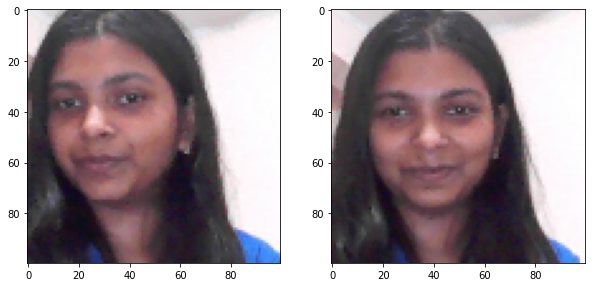

In [131]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

# 7. Save Model

In [127]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

In [132]:
L1Dist

__main__.L1Dist

In [133]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [134]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

array([[1.0000000e+00],
       [2.4904046e-11],
       [3.4595174e-11],
       [1.0000000e+00]], dtype=float32)

In [135]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_5 (L1Dist)              (None, 4096)         0           embedding[0][0]     

# 8. Real Time Test

## 8.1 Verification Function

In [ ]:
application_data\verification_images

In [161]:
os.listdir(os.path.join('application_data', 'verification_images'))

['86b4f501-c7c4-11ec-a388-2c8db1d65e0b.jpg',
 '876a6a2c-c7c4-11ec-9954-2c8db1d65e0b.jpg',
 '87894f71-c7c4-11ec-821a-2c8db1d65e0b.jpg',
 '878daa08-c7c4-11ec-90c0-2c8db1d65e0b.jpg',
 '87a2ef0b-c7c4-11ec-82c5-2c8db1d65e0b.jpg',
 '87a79c03-c7c4-11ec-a489-2c8db1d65e0b.jpg',
 '87ba93bf-c7c4-11ec-b2d3-2c8db1d65e0b.jpg',
 '87ecca16-c7c4-11ec-9362-2c8db1d65e0b.jpg',
 '87faf38c-c7c4-11ec-8401-2c8db1d65e0b.jpg',
 '880e0243-c7c4-11ec-9cee-2c8db1d65e0b.jpg',
 '881ea707-c7c4-11ec-a784-2c8db1d65e0b.jpg',
 '885eff5a-c7c4-11ec-a52a-2c8db1d65e0b.jpg',
 '886d37c0-c7c4-11ec-9f15-2c8db1d65e0b.jpg',
 '8871f559-c7c4-11ec-bebc-2c8db1d65e0b.jpg',
 '88769c7f-c7c4-11ec-bdbf-2c8db1d65e0b.jpg',
 '887b53e2-c7c4-11ec-9bfd-2c8db1d65e0b.jpg',
 '8884e1a0-c7c4-11ec-b458-2c8db1d65e0b.jpg',
 '8889a535-c7c4-11ec-b260-2c8db1d65e0b.jpg',
 '88a62a44-c7c4-11ec-a1b0-2c8db1d65e0b.jpg',
 '8904f63e-c7c4-11ec-9573-2c8db1d65e0b.jpg',
 '8917bed4-c7c4-11ec-966c-2c8db1d65e0b.jpg',
 '89346d21-c7c4-11ec-b94a-2c8db1d65e0b.jpg',
 '894e96bc

In [160]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [162]:

for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\86b4f501-c7c4-11ec-a388-2c8db1d65e0b.jpg
application_data\verification_images\876a6a2c-c7c4-11ec-9954-2c8db1d65e0b.jpg
application_data\verification_images\87894f71-c7c4-11ec-821a-2c8db1d65e0b.jpg
application_data\verification_images\878daa08-c7c4-11ec-90c0-2c8db1d65e0b.jpg
application_data\verification_images\87a2ef0b-c7c4-11ec-82c5-2c8db1d65e0b.jpg
application_data\verification_images\87a79c03-c7c4-11ec-a489-2c8db1d65e0b.jpg
application_data\verification_images\87ba93bf-c7c4-11ec-b2d3-2c8db1d65e0b.jpg
application_data\verification_images\87ecca16-c7c4-11ec-9362-2c8db1d65e0b.jpg
application_data\verification_images\87faf38c-c7c4-11ec-8401-2c8db1d65e0b.jpg
application_data\verification_images\880e0243-c7c4-11ec-9cee-2c8db1d65e0b.jpg
application_data\verification_images\881ea707-c7c4-11ec-a784-2c8db1d65e0b.jpg
application_data\verification_images\885eff5a-c7c4-11ec-a52a-2c8db1d65e0b.jpg
application_data\verification_images\886d37c0-c7c4-11ec-9f15-2c8

In [163]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified


## 8.2 OpenCV Real Time Verification

In [202]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

True
True
False
True


In [205]:
np.sum(np.squeeze(results) > 0.9)

34

In [206]:
results

[array([[0.14680418]], dtype=float32),
 array([[0.13474336]], dtype=float32),
 array([[0.48516512]], dtype=float32),
 array([[0.48516512]], dtype=float32),
 array([[0.5732986]], dtype=float32),
 array([[0.24134219]], dtype=float32),
 array([[0.02939603]], dtype=float32),
 array([[0.09031317]], dtype=float32),
 array([[0.41756094]], dtype=float32),
 array([[0.32010517]], dtype=float32),
 array([[0.50696665]], dtype=float32),
 array([[0.99993503]], dtype=float32),
 array([[0.99995524]], dtype=float32),
 array([[0.99995524]], dtype=float32),
 array([[0.9985697]], dtype=float32),
 array([[0.9985697]], dtype=float32),
 array([[0.9998806]], dtype=float32),
 array([[0.9999629]], dtype=float32),
 array([[0.9999877]], dtype=float32),
 array([[0.9986385]], dtype=float32),
 array([[0.99390745]], dtype=float32),
 array([[0.97903717]], dtype=float32),
 array([[0.0846543]], dtype=float32),
 array([[0.03328544]], dtype=float32),
 array([[0.9999817]], dtype=float32),
 array([[0.99991256]], dtype=float

def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

import os
import uuid

img_path = os.path.join(ANC_PATH, '924e839c-135f-11ec-b54e-a0cec8d2d278.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [ ]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img